# FHN ECG Fitting Demo

Demonstration of the **FitzHugh-Nagumo (FHN) ODE model** applied to ECG beats. 

This notebook visualizes a few example beats to show the quality of FHN fits, complementing the automated pipeline in `pipeline.py`.

## Files Required

Before running, please make sure you have the following file in the **main directory** (not inside `/demo`):
- `data/100_ekg.csv`  

This will be the example ECG data used for fitting.

In [2]:
import numpy as np
import pandas as pd
import neurokit2 as nk
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## FitzHugh-Nagumo ODE functions

In [3]:
def fhn(t, y, a, b, tau, I):
    v, w = y
    dv = v - v**3 / 3 - w + I
    dw = (v + a - b*w) / tau
    return [dv, dw]

def simulate_fhn(params, t_eval):
    a, b, tau, I, v0, w0 = params
    sol = solve_ivp(
        lambda t, y: fhn(t, y, a, b, tau, I),
        [0, t_eval[-1]],
        [v0, w0],
        t_eval=t_eval
    )
    return sol.y[0]

def loss(params, t_eval, ecg_subsampled):
    v_sim = simulate_fhn(params, t_eval)
    return np.sum((v_sim - ecg_subsampled)**2)

def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot

## Load ECG Data

In [4]:
fs = 360
ecg = pd.read_csv("../data/100_ekg.csv")["MLII"].values

# Detect R peaks
signals, info = nk.ecg_process(ecg, sampling_rate=fs)
rpeaks = info["ECG_R_Peaks"]

# Delineate ECG waves
_, waves = nk.ecg_delineate(ecg, rpeaks, sampling_rate=fs, method="dwt")
waves_df = pd.DataFrame(waves)
waves_df["rpeak"] = rpeaks

## Plot specific indices

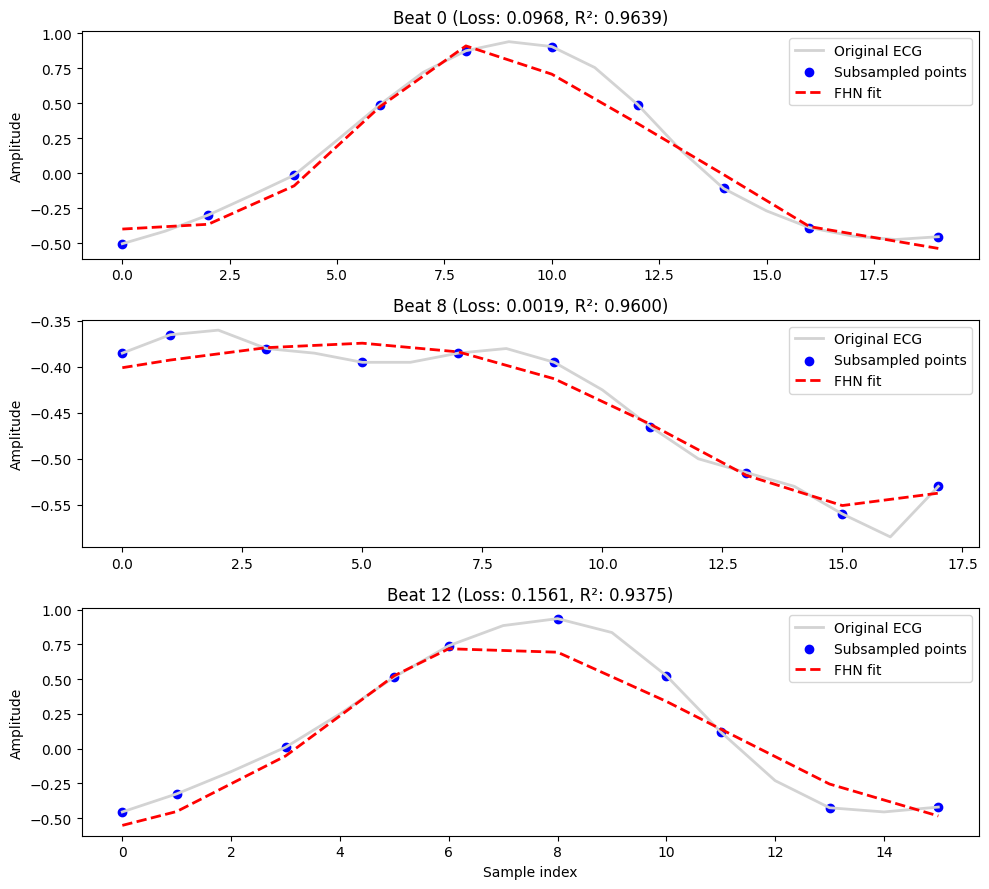

In [5]:
beat_indices = [0, 8, 12] 
num_points = 10  # number of points to fit

fig, axes = plt.subplots(len(beat_indices), 1, figsize=(10, 3*len(beat_indices)))

for idx_plot, beat_idx in enumerate(beat_indices):
    q_idx = int(waves_df.iloc[beat_idx]["ECG_Q_Peaks"])
    s_idx = int(waves_df.iloc[beat_idx]["ECG_S_Peaks"])
    ecg_segment = ecg[q_idx:s_idx+1]
    t_segment = np.arange(len(ecg_segment))
    
    # Subsample points
    indices = np.linspace(0, len(ecg_segment)-1, num_points, dtype=int)
    ecg_subsampled = ecg_segment[indices]
    t_subsampled = t_segment[indices]
    
    # Initial guess for FHN
    params0 = [1, 1, 1, 0.5, ecg_subsampled[0], 0.0]
    
    # Fit FHN
    res = minimize(loss, params0, args=(t_subsampled, ecg_subsampled), method='Nelder-Mead')
    fitted_params = res.x
    
    # Simulate FHN
    v_fit = simulate_fhn(fitted_params, t_subsampled)
    
    # Compute metrics
    beat_loss = loss(fitted_params, t_subsampled, ecg_subsampled)
    beat_r2 = r_squared(ecg_subsampled, v_fit)
    
    # Plot
    ax = axes[idx_plot]
    ax.plot(t_segment, ecg_segment, color='lightgray', linewidth=2, label="Original ECG")
    ax.scatter(t_subsampled, ecg_subsampled, color='blue', label="Subsampled points")
    ax.plot(t_subsampled, v_fit, 'r--', linewidth=2, label="FHN fit")
    ax.set_ylabel("Amplitude")
    ax.set_title(f"Beat {beat_idx} (Loss: {beat_loss:.4f}, R²: {beat_r2:.4f})")
    ax.legend(loc='upper right')

axes[-1].set_xlabel("Sample index")
plt.tight_layout()
plt.show()